In [1]:
import torch
import torch.nn as nn

# 先写一些最基础的卷积层

# group 相当于将in_channel均分为group份，每份分别卷积，相对于group=1的卷积，group=n卷积需要的卷积核参数是group=1的1/n，group=n的卷积核完全没有channel间的感受野
def conv3x3(in_channels, out_channels, stride=2, padding=1, groups=1):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding, groups=groups)

# conv1x1是另一个极端，完全没有channel内的感受野，但是也有很多应用，controlnet就是用conv1x1调参的
def conv1x1(in_channels, out_channels, stride=1, padding=0, groups=1):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding, groups=groups)

这张图来自resnet论文，我们来把这个结构复现出来，同时照着pytorch官方的实现，来提供一组易于拓展的resnet(想不到我居然会有一天在python里研究设计模式...)    
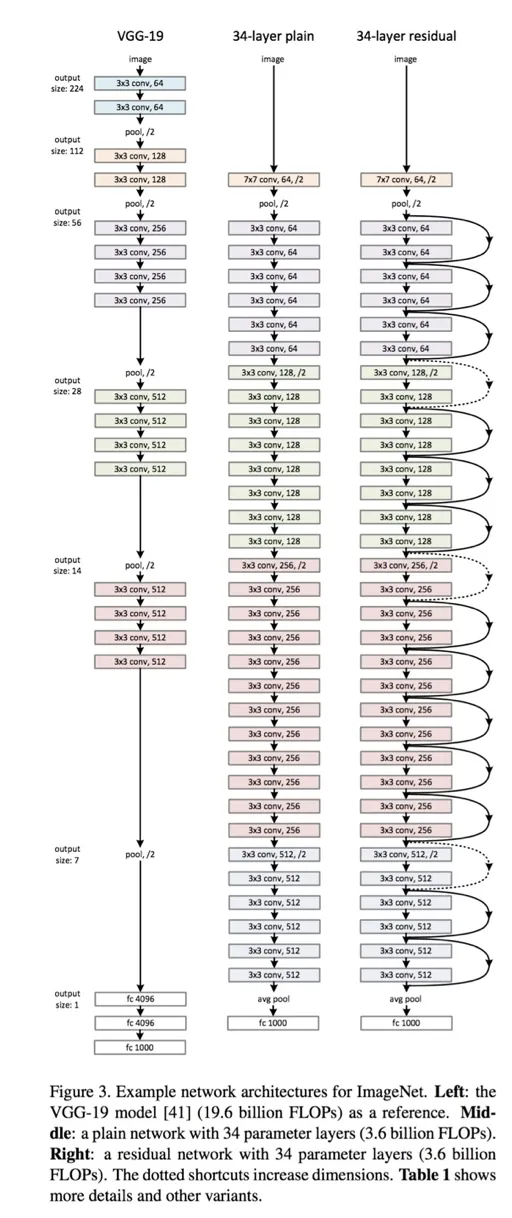  

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, channels, stride=1, basic_width=64, group=1, padding=1, norm_layer=None, downsample=None):
        super(BasicBlock, self).__init__() 
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(in_channels=in_channels, out_channels=channels, stride=stride)
        self.bn1 = norm_layer(in_channels=channels)
        # stride只会生效一次，我想主要是为了方便downsample层
        self.conv2 = conv3x3(in_channels=channels, out_channels=channels)
        self.bn2 = norm_layer(in_channels=channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identical = x # 存下来用来做残差
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)

        # 这里downsample的作用我的理解是：默认resnet是直接将identical加到输出里，不做什么变化，这样不会引入什么参数，但是啊，有时候block之间的channel数它变了，所以需要一个downsample层来把identical也变到目标channel
        if self.downsample is not None:
            identical = self.downsample(identical)
        
        return self.relu(x+identical)



basic block就是我们在上面的图里看到的结构，但是resnet比较厚的网络，使用的都是bottleneck来完成连接  

In [3]:
class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, channels, basic_width=64, stride=1, padding=1, groups=1, norm_layer=None, downsample=None):
        # 直观来看，bottleneck会对较大的输入和分出的group通过增加channel数量来补偿, 对于group总是要保证参数量和groups=1时一致，对于更大的图片，则按宽之比放缩参数量
        super().__init__()
        width = channels * ((int)(basic_width / 64)) * groups
        if norm_layer == None:
            norm_layer = nn.BatchNorm2d
        # TODO 我对这种设计的用心很好奇，看起来它们用两个conv1x1代替了 basicblock里的conv3x3，但是这么一来，单个block的通道内感知能力不是明显下降了么
        self.conv1 = conv1x1(in_channels=in_channels, out_channels=width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(in_channels=width, out_channels=width, groups=groups, stride=stride, padding=padding)
        self.bn2 = norm_layer(width)
        # TODO expansion... 看起来最后信息又全部被规约到一个与图像大小本身无关的恒定的大小了，感觉直觉上来讲的话，conv2用来确保即便图像大，对图像的理解也足够深（但是这水平感受野也没变啊...）conv3则要求不论图像多大，最后抽出来的信息量应当是符合channels参数的？？？
        self.conv3 = conv1x1(in_channels=width, out_channels=channels*self.expansion)
        self.bn3 = norm_layer(channels*self.expansion)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        # print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample != None:
            identity = self.downsample(identity)
        # TODO 为啥这里不过bnorm了啊？
        return self.relu(x+identity)



接下来我们实现resnet的主类

In [4]:
# 不带类型写起来真的太痛苦了
from typing import Union, Type, List


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        num_blocks: List[int],
        basic_width=64,
        norm_layer=None,
        groups=1,
        num_classes=1000,
    ):
        super().__init__()
        self.basic_width = basic_width
        self.groups = groups
        if norm_layer == None:
            self.norm_layer = nn.BatchNorm2d
        else:
            self.norm_layer = norm_layer
        # 威什么这个inchannel不能让用户自己定义呢...好像用户自己定一个数也不碍事啊
        self.in_channels = 64
        # 这里的卷积后size大小是 (size-7+6)/2+1 = size/2+0.5 pytorch的conv实现会自动向下取整，个人猜测就是直接放弃最后一次无法完成的卷积，而我们这个stride的余数反正只能是0,1，
        # 关于Maxpool2D和的反向传播法则可以看这两篇： 1.https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers 2.https://towardsdatascience.com/backpropagation-in-fully-convolutional-networks-fcns-1a13b75fb56a
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=self.in_channels, kernel_size=7, padding=3
        )
        self.bn1 = self.norm_layer(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(
            block=block, channels=64, num_inside_layers=num_blocks[0]
        )
        self.layer2 = self._make_layer(
            block=block, channels=128, num_inside_layers=num_blocks[1], stride=2
        )
        self.layer3 = self._make_layer(
            block=block, channels=256, num_inside_layers=num_blocks[2], stride=2
        )
        self.layer4 = self._make_layer(
            block=block, channels=512, num_inside_layers=num_blocks[3], stride=2
        )
        # AdaptiveAvgPool 让我们不必单独再去设计核的大小，而是只需要设定下输出大小就好了 具体计算看这里，我有点不想去细究除不尽之类的话题了 https://stackoverflow.com/questions/58692476/what-is-adaptive-average-pooling-and-how-does-it-work/58694174#58694174
        # 这个pooling相当于每个channel，最后你就输出一个值啊
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 这个就是输出了
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 接下来就是权重参数的初始化了
        # 这里对卷积核的初始化采用了Kaiming Initialization https://paperswithcode.com/method/he-initialization，它会照着某种正太分布来初始化网络权重 TODO 进一步了解kaiming initialization
        # 这种初始化方式可以避免初始的参数连续指向某个增长方向甚至指数化放缩参数的情况，这可能导致网络很难训练
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # TODO 区分fan_in fan_out
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                # TODO batchnorm的过程有记不清了，主要是这两个权重是干啥的
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # TODO 这里还有一个经典的优化叫zero_init_residual 得去看看

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, BottleNeck]],
        channels,
        num_inside_layers,
        stride=1,
    ):
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_channels, channels * block.expansion, stride=stride),
                self.norm_layer(channels * block.expansion),
            )
        layers = []
        layers.append(
            block(
                in_channels=self.in_channels,
                channels=channels,
                basic_width=self.basic_width,
                stride=stride,
                padding=1,
                groups=self.groups,
                norm_layer=self.norm_layer,
                downsample=downsample,
            )
        )
        self.in_channels = channels * block.expansion
        for _ in range(1, num_inside_layers):
            layers.append(
                block(
                    in_channels=self.in_channels,
                    channels=channels,
                    groups=self.groups,
                    basic_width=self.basic_width,
                    norm_layer=self.norm_layer,
                )
            )
        return nn.Sequential(*layers)

    def forward(self, x):

        # print('forward start')
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # TODO 啊不是这都还没啥感受野啊，这就开始maxpool合适吗

        # print('to layer1')
        x = self.layer1(x)
        # print('to layer2')
        x = self.layer2(x)
        # print('to layer3')
        x = self.layer3(x)
        # print('to layer4')
        x = self.layer4(x)

        x = self.avgpool(x)
        # 将1*1的H*W的x拉成一条直的向量，也就成为了 (batch, num_class)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

接下来我们利用之前的类来构建一个基础的resnet50

In [5]:
# 为啥叫ResNet50，50层是怎么算的: 首先开始就有一个7*7卷积，num_layers是[3, 4, 6, 3]，也就是16个block，每个block是bottleneck，bottleneck有2个conv1*1和1个conv3*3，也就是48层，最后还有一个linear层，所以一起就是1+48+1=50
class resnet50_me(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model = ResNet(BottleNeck, [3, 4, 6, 3], num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

接下来我们来训练和测试这个模型，使用cifar100，并和官方模型的效果做一个比较

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


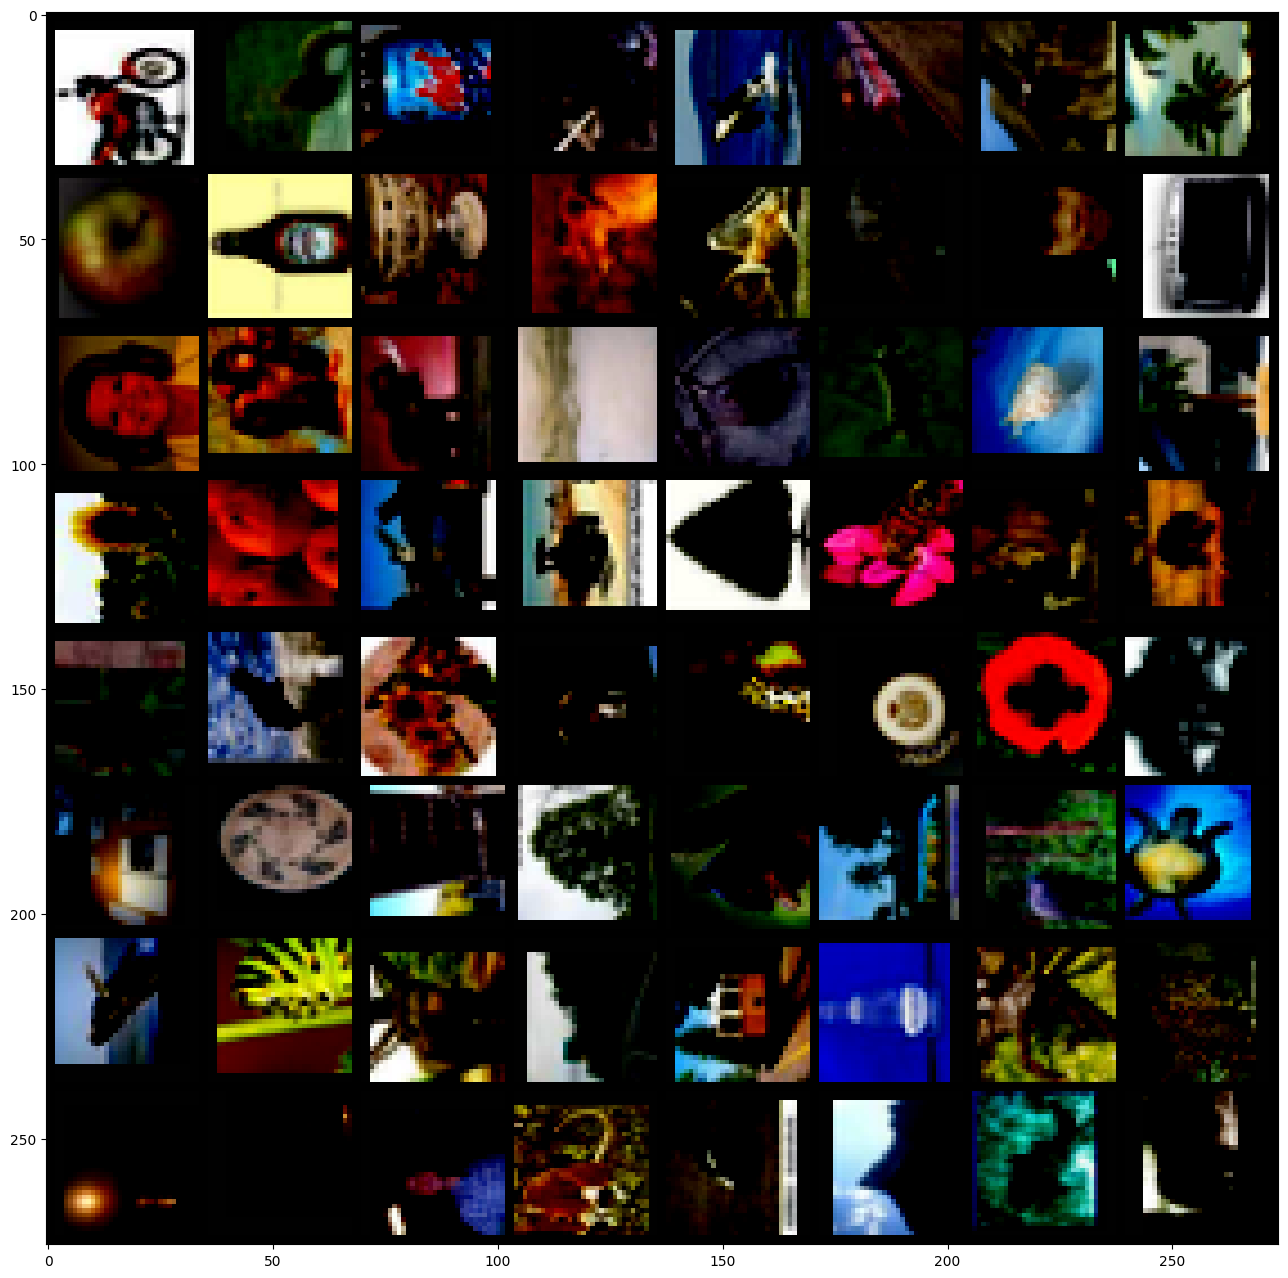

In [6]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

import torchvision.datasets as tvdata
import torchvision.utils as tvutil
import torchvision.transforms as transforms
import torch.utils.data as tdata
import matplotlib.pyplot as plt 
import numpy as np

# 这次试试normalize之后的表现
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,.05), (0.5,0.5,0.5))])
# 做一些简单的数据扰动，省得模型自以为是
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32, padding=4, fill=128), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,.05), (0.5,0.5,0.5))])

trainset = tvdata.CIFAR100(root='./data', train=True, transform=train_transform, download=True)
testset = tvdata.CIFAR100(root='./data', train=False, transform=transform, download=True)

trainloader = tdata.DataLoader(dataset=trainset, batch_size=64, shuffle=True)
testloader = tdata.DataLoader(dataset=testset, batch_size=64, shuffle=False)

images, labels = next(iter(trainloader))
plt.figure(figsize=(16,16))
plt.imshow(np.transpose(tvutil.make_grid(images).cpu(), (2, 1, 0)))



训练

In [12]:
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from resnet import resnet50

model = resnet50(num_classes=100)
model.to(device)
print(model)
optimizer = Adam(model.parameters(), lr=0.001)
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

epochs = 40
writer = SummaryWriter(log_dir='./runs/official_random_flip_random_crop')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    total = 0
    correct = 0
    # noise = torch.linspace(0.3, 0, epochs) #扰动10%到完全不扰动
    for i, data in enumerate(trainloader, 0):
        batch, labels = data
        batch = batch.to(device)
        labels = labels.to(device)
        # 这次我们随机地以线性下降的概率扰动真实值
        # p = 1 - noise[epoch] # 计算以1的概率
        # mask = torch.bernoulli(torch.ones_like(labels) * p) # 生成随机张量
        # random_labels = torch.randint(1, 101, size=labels.size(), device=device) # 生成1-100的随机整数
        # new_labels = torch.where(mask == 1, labels, random_labels) # 根据随机张量替换标签，不为1就替换
        # 接下来使用new_labels进行训练
        # 每轮开始前都要清零权重，否则之前的影响会叠加
        optimizer.zero_grad()
        out, _ = model(batch)
        # loss = criterion(out, new_labels)
        loss = criterion(out[0], labels)
        loss.backward()
        optimizer.step()
        print(f'training epoch: {epoch}, i: {i}')
        _, predict = torch.max(out[0], 1)
        total += labels.size()[0]
        correct += (predict == labels).sum().item()
        running_loss += loss.item()
        epoch_loss += loss.item()

        if i % 100 == 99:
            avg_loss = running_loss / 100
            running_loss = 0.0
            print(f'loss {avg_loss}')
    writer.add_scalar('Loss/Train', epoch_loss / total, epoch)
    writer.add_scalar('Accuarcy', correct / total, epoch)

    model.eval()

    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(testloader):
            batch, labels = data
            batch = batch.to(device)
            labels = labels.to(device)
            out, _ = model(batch)
            _, predict = torch.max(out[0], 1)
            test_loss += criterion(out[0], labels)
            total += labels.size()[0]
            correct += (predict == labels).sum().item()

        print(f'test avg loss: {test_loss / len(testloader)}, accuracy: {correct / total:.2f}')
        writer.add_scalar('Test Accuarcy', correct / total, epoch)

model_path = './model_40_official.pth'
torch.save(model.state_dict(), model_path)


# model.eval()
# model.to(device)

# with torch.no_grad():
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     for i, data in enumerate(testloader):
#         batch, labels = data
#         out = model(batch)
#         test_loss += criterion(out, labels)
#         _, predict = torch.max(out, 1)
#         total += labels.size()[0]
#         correct += (predict == labels).sum().item()

#     print(f'test avg loss: {test_loss / len(testloader)}, accuracy: {correct / total:.2f}')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

测试保存的模型

In [9]:
model = resnet50(num_classes=100)

model.load_state_dict(torch.load('./model_10.pth', map_location=device, weights_only=True))
criterion = nn.CrossEntropyLoss()
model.to(device)
model.eval()

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(testloader):
        batch, labels = data
        batch = batch.to(device)
        labels = labels.to(device)
        out = model(batch)
        _, predict = torch.max(out, 1)
        test_loss += criterion(out, labels)
        total += labels.size()[0]
        correct += (predict == labels).sum().item()

    print(f'test avg loss: {test_loss / len(testloader)}, accuracy: {correct / total:.2f}')

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "scala1.0.op.0.weight", "scala1.0.op.1.weight", "scala1.0.op.2.weight", "scala1.0.op.2.bias", "scala1.0.op.2.running_mean", "scala1.0.op.2.running_var", "scala1.0.op.4.weight", "scala1.0.op.5.weight", "scala1.0.op.6.weight", "scala1.0.op.6.bias", "scala1.0.op.6.running_mean", "scala1.0.op.6.running_var", "scala1.1.op.0.weight", "scala1.1.op.1.weight", "scala1.1.op.2.weight", "scala1.1.op.2.bias", "scala1.1.op.2.running_mean", "scala1.1.op.2.running_var", "scala1.1.op.4.weight", "scala1.1.op.5.weight", "scala1.1.op.6.weight", "scala1.1.op.6.bias", "scala1.1.op.6.running_mean", "scala1.1.op.6.running_var", "scala1.2.op.0.weight", "scala1.2.op.1.weight", "scala1.2.op.2.weight", "scala1.2.op.2.bias", "scala1.2.op.2.running_mean", "scala1.2.op.2.running_var", "scala1.2.op.4.weight", "scala1.2.op.5.weight", "scala1.2.op.6.weight", "scala1.2.op.6.bias", "scala1.2.op.6.running_mean", "scala1.2.op.6.running_var", "scala2.0.op.0.weight", "scala2.0.op.1.weight", "scala2.0.op.2.weight", "scala2.0.op.2.bias", "scala2.0.op.2.running_mean", "scala2.0.op.2.running_var", "scala2.0.op.4.weight", "scala2.0.op.5.weight", "scala2.0.op.6.weight", "scala2.0.op.6.bias", "scala2.0.op.6.running_mean", "scala2.0.op.6.running_var", "scala2.1.op.0.weight", "scala2.1.op.1.weight", "scala2.1.op.2.weight", "scala2.1.op.2.bias", "scala2.1.op.2.running_mean", "scala2.1.op.2.running_var", "scala2.1.op.4.weight", "scala2.1.op.5.weight", "scala2.1.op.6.weight", "scala2.1.op.6.bias", "scala2.1.op.6.running_mean", "scala2.1.op.6.running_var", "scala3.0.op.0.weight", "scala3.0.op.1.weight", "scala3.0.op.2.weight", "scala3.0.op.2.bias", "scala3.0.op.2.running_mean", "scala3.0.op.2.running_var", "scala3.0.op.4.weight", "scala3.0.op.5.weight", "scala3.0.op.6.weight", "scala3.0.op.6.bias", "scala3.0.op.6.running_mean", "scala3.0.op.6.running_var", "attention1.0.op.0.weight", "attention1.0.op.1.weight", "attention1.0.op.2.weight", "attention1.0.op.2.bias", "attention1.0.op.2.running_mean", "attention1.0.op.2.running_var", "attention1.0.op.4.weight", "attention1.0.op.5.weight", "attention1.0.op.6.weight", "attention1.0.op.6.bias", "attention1.0.op.6.running_mean", "attention1.0.op.6.running_var", "attention1.1.weight", "attention1.1.bias", "attention1.1.running_mean", "attention1.1.running_var", "attention2.0.op.0.weight", "attention2.0.op.1.weight", "attention2.0.op.2.weight", "attention2.0.op.2.bias", "attention2.0.op.2.running_mean", "attention2.0.op.2.running_var", "attention2.0.op.4.weight", "attention2.0.op.5.weight", "attention2.0.op.6.weight", "attention2.0.op.6.bias", "attention2.0.op.6.running_mean", "attention2.0.op.6.running_var", "attention2.1.weight", "attention2.1.bias", "attention2.1.running_mean", "attention2.1.running_var", "attention3.0.op.0.weight", "attention3.0.op.1.weight", "attention3.0.op.2.weight", "attention3.0.op.2.bias", "attention3.0.op.2.running_mean", "attention3.0.op.2.running_var", "attention3.0.op.4.weight", "attention3.0.op.5.weight", "attention3.0.op.6.weight", "attention3.0.op.6.bias", "attention3.0.op.6.running_mean", "attention3.0.op.6.running_var", "attention3.1.weight", "attention3.1.bias", "attention3.1.running_mean", "attention3.1.running_var", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias", "fc4.weight", "fc4.bias". 
	Unexpected key(s) in state_dict: "model.conv1_0.weight", "model.conv1_0.bias", "model.conv1_1.weight", "model.conv1_1.bias", "model.conv1_2.weight", "model.conv1_2.bias", "model.bn1.weight", "model.bn1.bias", "model.bn1.running_mean", "model.bn1.running_var", "model.bn1.num_batches_tracked", "model.layer1.0.conv1.weight", "model.layer1.0.conv1.bias", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.bn1.num_batches_tracked", "model.layer1.0.conv2.weight", "model.layer1.0.conv2.bias", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.0.bn2.num_batches_tracked", "model.layer1.0.conv3.weight", "model.layer1.0.conv3.bias", "model.layer1.0.bn3.weight", "model.layer1.0.bn3.bias", "model.layer1.0.bn3.running_mean", "model.layer1.0.bn3.running_var", "model.layer1.0.bn3.num_batches_tracked", "model.layer1.0.downsample.0.weight", "model.layer1.0.downsample.0.bias", "model.layer1.0.downsample.1.weight", "model.layer1.0.downsample.1.bias", "model.layer1.0.downsample.1.running_mean", "model.layer1.0.downsample.1.running_var", "model.layer1.0.downsample.1.num_batches_tracked", "model.layer1.1.conv1.weight", "model.layer1.1.conv1.bias", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.bn1.num_batches_tracked", "model.layer1.1.conv2.weight", "model.layer1.1.conv2.bias", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer1.1.bn2.num_batches_tracked", "model.layer1.1.conv3.weight", "model.layer1.1.conv3.bias", "model.layer1.1.bn3.weight", "model.layer1.1.bn3.bias", "model.layer1.1.bn3.running_mean", "model.layer1.1.bn3.running_var", "model.layer1.1.bn3.num_batches_tracked", "model.layer1.2.conv1.weight", "model.layer1.2.conv1.bias", "model.layer1.2.bn1.weight", "model.layer1.2.bn1.bias", "model.layer1.2.bn1.running_mean", "model.layer1.2.bn1.running_var", "model.layer1.2.bn1.num_batches_tracked", "model.layer1.2.conv2.weight", "model.layer1.2.conv2.bias", "model.layer1.2.bn2.weight", "model.layer1.2.bn2.bias", "model.layer1.2.bn2.running_mean", "model.layer1.2.bn2.running_var", "model.layer1.2.bn2.num_batches_tracked", "model.layer1.2.conv3.weight", "model.layer1.2.conv3.bias", "model.layer1.2.bn3.weight", "model.layer1.2.bn3.bias", "model.layer1.2.bn3.running_mean", "model.layer1.2.bn3.running_var", "model.layer1.2.bn3.num_batches_tracked", "model.layer2.0.conv1.weight", "model.layer2.0.conv1.bias", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.bn1.num_batches_tracked", "model.layer2.0.conv2.weight", "model.layer2.0.conv2.bias", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.bn2.num_batches_tracked", "model.layer2.0.conv3.weight", "model.layer2.0.conv3.bias", "model.layer2.0.bn3.weight", "model.layer2.0.bn3.bias", "model.layer2.0.bn3.running_mean", "model.layer2.0.bn3.running_var", "model.layer2.0.bn3.num_batches_tracked", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.0.bias", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.0.downsample.1.num_batches_tracked", "model.layer2.1.conv1.weight", "model.layer2.1.conv1.bias", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.bn1.num_batches_tracked", "model.layer2.1.conv2.weight", "model.layer2.1.conv2.bias", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer2.1.bn2.num_batches_tracked", "model.layer2.1.conv3.weight", "model.layer2.1.conv3.bias", "model.layer2.1.bn3.weight", "model.layer2.1.bn3.bias", "model.layer2.1.bn3.running_mean", "model.layer2.1.bn3.running_var", "model.layer2.1.bn3.num_batches_tracked", "model.layer2.2.conv1.weight", "model.layer2.2.conv1.bias", "model.layer2.2.bn1.weight", "model.layer2.2.bn1.bias", "model.layer2.2.bn1.running_mean", "model.layer2.2.bn1.running_var", "model.layer2.2.bn1.num_batches_tracked", "model.layer2.2.conv2.weight", "model.layer2.2.conv2.bias", "model.layer2.2.bn2.weight", "model.layer2.2.bn2.bias", "model.layer2.2.bn2.running_mean", "model.layer2.2.bn2.running_var", "model.layer2.2.bn2.num_batches_tracked", "model.layer2.2.conv3.weight", "model.layer2.2.conv3.bias", "model.layer2.2.bn3.weight", "model.layer2.2.bn3.bias", "model.layer2.2.bn3.running_mean", "model.layer2.2.bn3.running_var", "model.layer2.2.bn3.num_batches_tracked", "model.layer2.3.conv1.weight", "model.layer2.3.conv1.bias", "model.layer2.3.bn1.weight", "model.layer2.3.bn1.bias", "model.layer2.3.bn1.running_mean", "model.layer2.3.bn1.running_var", "model.layer2.3.bn1.num_batches_tracked", "model.layer2.3.conv2.weight", "model.layer2.3.conv2.bias", "model.layer2.3.bn2.weight", "model.layer2.3.bn2.bias", "model.layer2.3.bn2.running_mean", "model.layer2.3.bn2.running_var", "model.layer2.3.bn2.num_batches_tracked", "model.layer2.3.conv3.weight", "model.layer2.3.conv3.bias", "model.layer2.3.bn3.weight", "model.layer2.3.bn3.bias", "model.layer2.3.bn3.running_mean", "model.layer2.3.bn3.running_var", "model.layer2.3.bn3.num_batches_tracked", "model.layer3.0.conv1.weight", "model.layer3.0.conv1.bias", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.bn1.num_batches_tracked", "model.layer3.0.conv2.weight", "model.layer3.0.conv2.bias", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.bn2.num_batches_tracked", "model.layer3.0.conv3.weight", "model.layer3.0.conv3.bias", "model.layer3.0.bn3.weight", "model.layer3.0.bn3.bias", "model.layer3.0.bn3.running_mean", "model.layer3.0.bn3.running_var", "model.layer3.0.bn3.num_batches_tracked", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.0.bias", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.0.downsample.1.num_batches_tracked", "model.layer3.1.conv1.weight", "model.layer3.1.conv1.bias", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.bn1.num_batches_tracked", "model.layer3.1.conv2.weight", "model.layer3.1.conv2.bias", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer3.1.bn2.num_batches_tracked", "model.layer3.1.conv3.weight", "model.layer3.1.conv3.bias", "model.layer3.1.bn3.weight", "model.layer3.1.bn3.bias", "model.layer3.1.bn3.running_mean", "model.layer3.1.bn3.running_var", "model.layer3.1.bn3.num_batches_tracked", "model.layer3.2.conv1.weight", "model.layer3.2.conv1.bias", "model.layer3.2.bn1.weight", "model.layer3.2.bn1.bias", "model.layer3.2.bn1.running_mean", "model.layer3.2.bn1.running_var", "model.layer3.2.bn1.num_batches_tracked", "model.layer3.2.conv2.weight", "model.layer3.2.conv2.bias", "model.layer3.2.bn2.weight", "model.layer3.2.bn2.bias", "model.layer3.2.bn2.running_mean", "model.layer3.2.bn2.running_var", "model.layer3.2.bn2.num_batches_tracked", "model.layer3.2.conv3.weight", "model.layer3.2.conv3.bias", "model.layer3.2.bn3.weight", "model.layer3.2.bn3.bias", "model.layer3.2.bn3.running_mean", "model.layer3.2.bn3.running_var", "model.layer3.2.bn3.num_batches_tracked", "model.layer3.3.conv1.weight", "model.layer3.3.conv1.bias", "model.layer3.3.bn1.weight", "model.layer3.3.bn1.bias", "model.layer3.3.bn1.running_mean", "model.layer3.3.bn1.running_var", "model.layer3.3.bn1.num_batches_tracked", "model.layer3.3.conv2.weight", "model.layer3.3.conv2.bias", "model.layer3.3.bn2.weight", "model.layer3.3.bn2.bias", "model.layer3.3.bn2.running_mean", "model.layer3.3.bn2.running_var", "model.layer3.3.bn2.num_batches_tracked", "model.layer3.3.conv3.weight", "model.layer3.3.conv3.bias", "model.layer3.3.bn3.weight", "model.layer3.3.bn3.bias", "model.layer3.3.bn3.running_mean", "model.layer3.3.bn3.running_var", "model.layer3.3.bn3.num_batches_tracked", "model.layer3.4.conv1.weight", "model.layer3.4.conv1.bias", "model.layer3.4.bn1.weight", "model.layer3.4.bn1.bias", "model.layer3.4.bn1.running_mean", "model.layer3.4.bn1.running_var", "model.layer3.4.bn1.num_batches_tracked", "model.layer3.4.conv2.weight", "model.layer3.4.conv2.bias", "model.layer3.4.bn2.weight", "model.layer3.4.bn2.bias", "model.layer3.4.bn2.running_mean", "model.layer3.4.bn2.running_var", "model.layer3.4.bn2.num_batches_tracked", "model.layer3.4.conv3.weight", "model.layer3.4.conv3.bias", "model.layer3.4.bn3.weight", "model.layer3.4.bn3.bias", "model.layer3.4.bn3.running_mean", "model.layer3.4.bn3.running_var", "model.layer3.4.bn3.num_batches_tracked", "model.layer3.5.conv1.weight", "model.layer3.5.conv1.bias", "model.layer3.5.bn1.weight", "model.layer3.5.bn1.bias", "model.layer3.5.bn1.running_mean", "model.layer3.5.bn1.running_var", "model.layer3.5.bn1.num_batches_tracked", "model.layer3.5.conv2.weight", "model.layer3.5.conv2.bias", "model.layer3.5.bn2.weight", "model.layer3.5.bn2.bias", "model.layer3.5.bn2.running_mean", "model.layer3.5.bn2.running_var", "model.layer3.5.bn2.num_batches_tracked", "model.layer3.5.conv3.weight", "model.layer3.5.conv3.bias", "model.layer3.5.bn3.weight", "model.layer3.5.bn3.bias", "model.layer3.5.bn3.running_mean", "model.layer3.5.bn3.running_var", "model.layer3.5.bn3.num_batches_tracked", "model.layer4.0.conv1.weight", "model.layer4.0.conv1.bias", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.bn1.num_batches_tracked", "model.layer4.0.conv2.weight", "model.layer4.0.conv2.bias", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.bn2.num_batches_tracked", "model.layer4.0.conv3.weight", "model.layer4.0.conv3.bias", "model.layer4.0.bn3.weight", "model.layer4.0.bn3.bias", "model.layer4.0.bn3.running_mean", "model.layer4.0.bn3.running_var", "model.layer4.0.bn3.num_batches_tracked", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.0.bias", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.0.downsample.1.num_batches_tracked", "model.layer4.1.conv1.weight", "model.layer4.1.conv1.bias", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.bn1.num_batches_tracked", "model.layer4.1.conv2.weight", "model.layer4.1.conv2.bias", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.layer4.1.bn2.num_batches_tracked", "model.layer4.1.conv3.weight", "model.layer4.1.conv3.bias", "model.layer4.1.bn3.weight", "model.layer4.1.bn3.bias", "model.layer4.1.bn3.running_mean", "model.layer4.1.bn3.running_var", "model.layer4.1.bn3.num_batches_tracked", "model.layer4.2.conv1.weight", "model.layer4.2.conv1.bias", "model.layer4.2.bn1.weight", "model.layer4.2.bn1.bias", "model.layer4.2.bn1.running_mean", "model.layer4.2.bn1.running_var", "model.layer4.2.bn1.num_batches_tracked", "model.layer4.2.conv2.weight", "model.layer4.2.conv2.bias", "model.layer4.2.bn2.weight", "model.layer4.2.bn2.bias", "model.layer4.2.bn2.running_mean", "model.layer4.2.bn2.running_var", "model.layer4.2.bn2.num_batches_tracked", "model.layer4.2.conv3.weight", "model.layer4.2.conv3.bias", "model.layer4.2.bn3.weight", "model.layer4.2.bn3.bias", "model.layer4.2.bn3.running_mean", "model.layer4.2.bn3.running_var", "model.layer4.2.bn3.num_batches_tracked", "model.fc.weight", "model.fc.bias". 